In [4]:
from PIL import Image
import cv2 
from IPython.display import display

def imgshow(img) -> None:
    display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

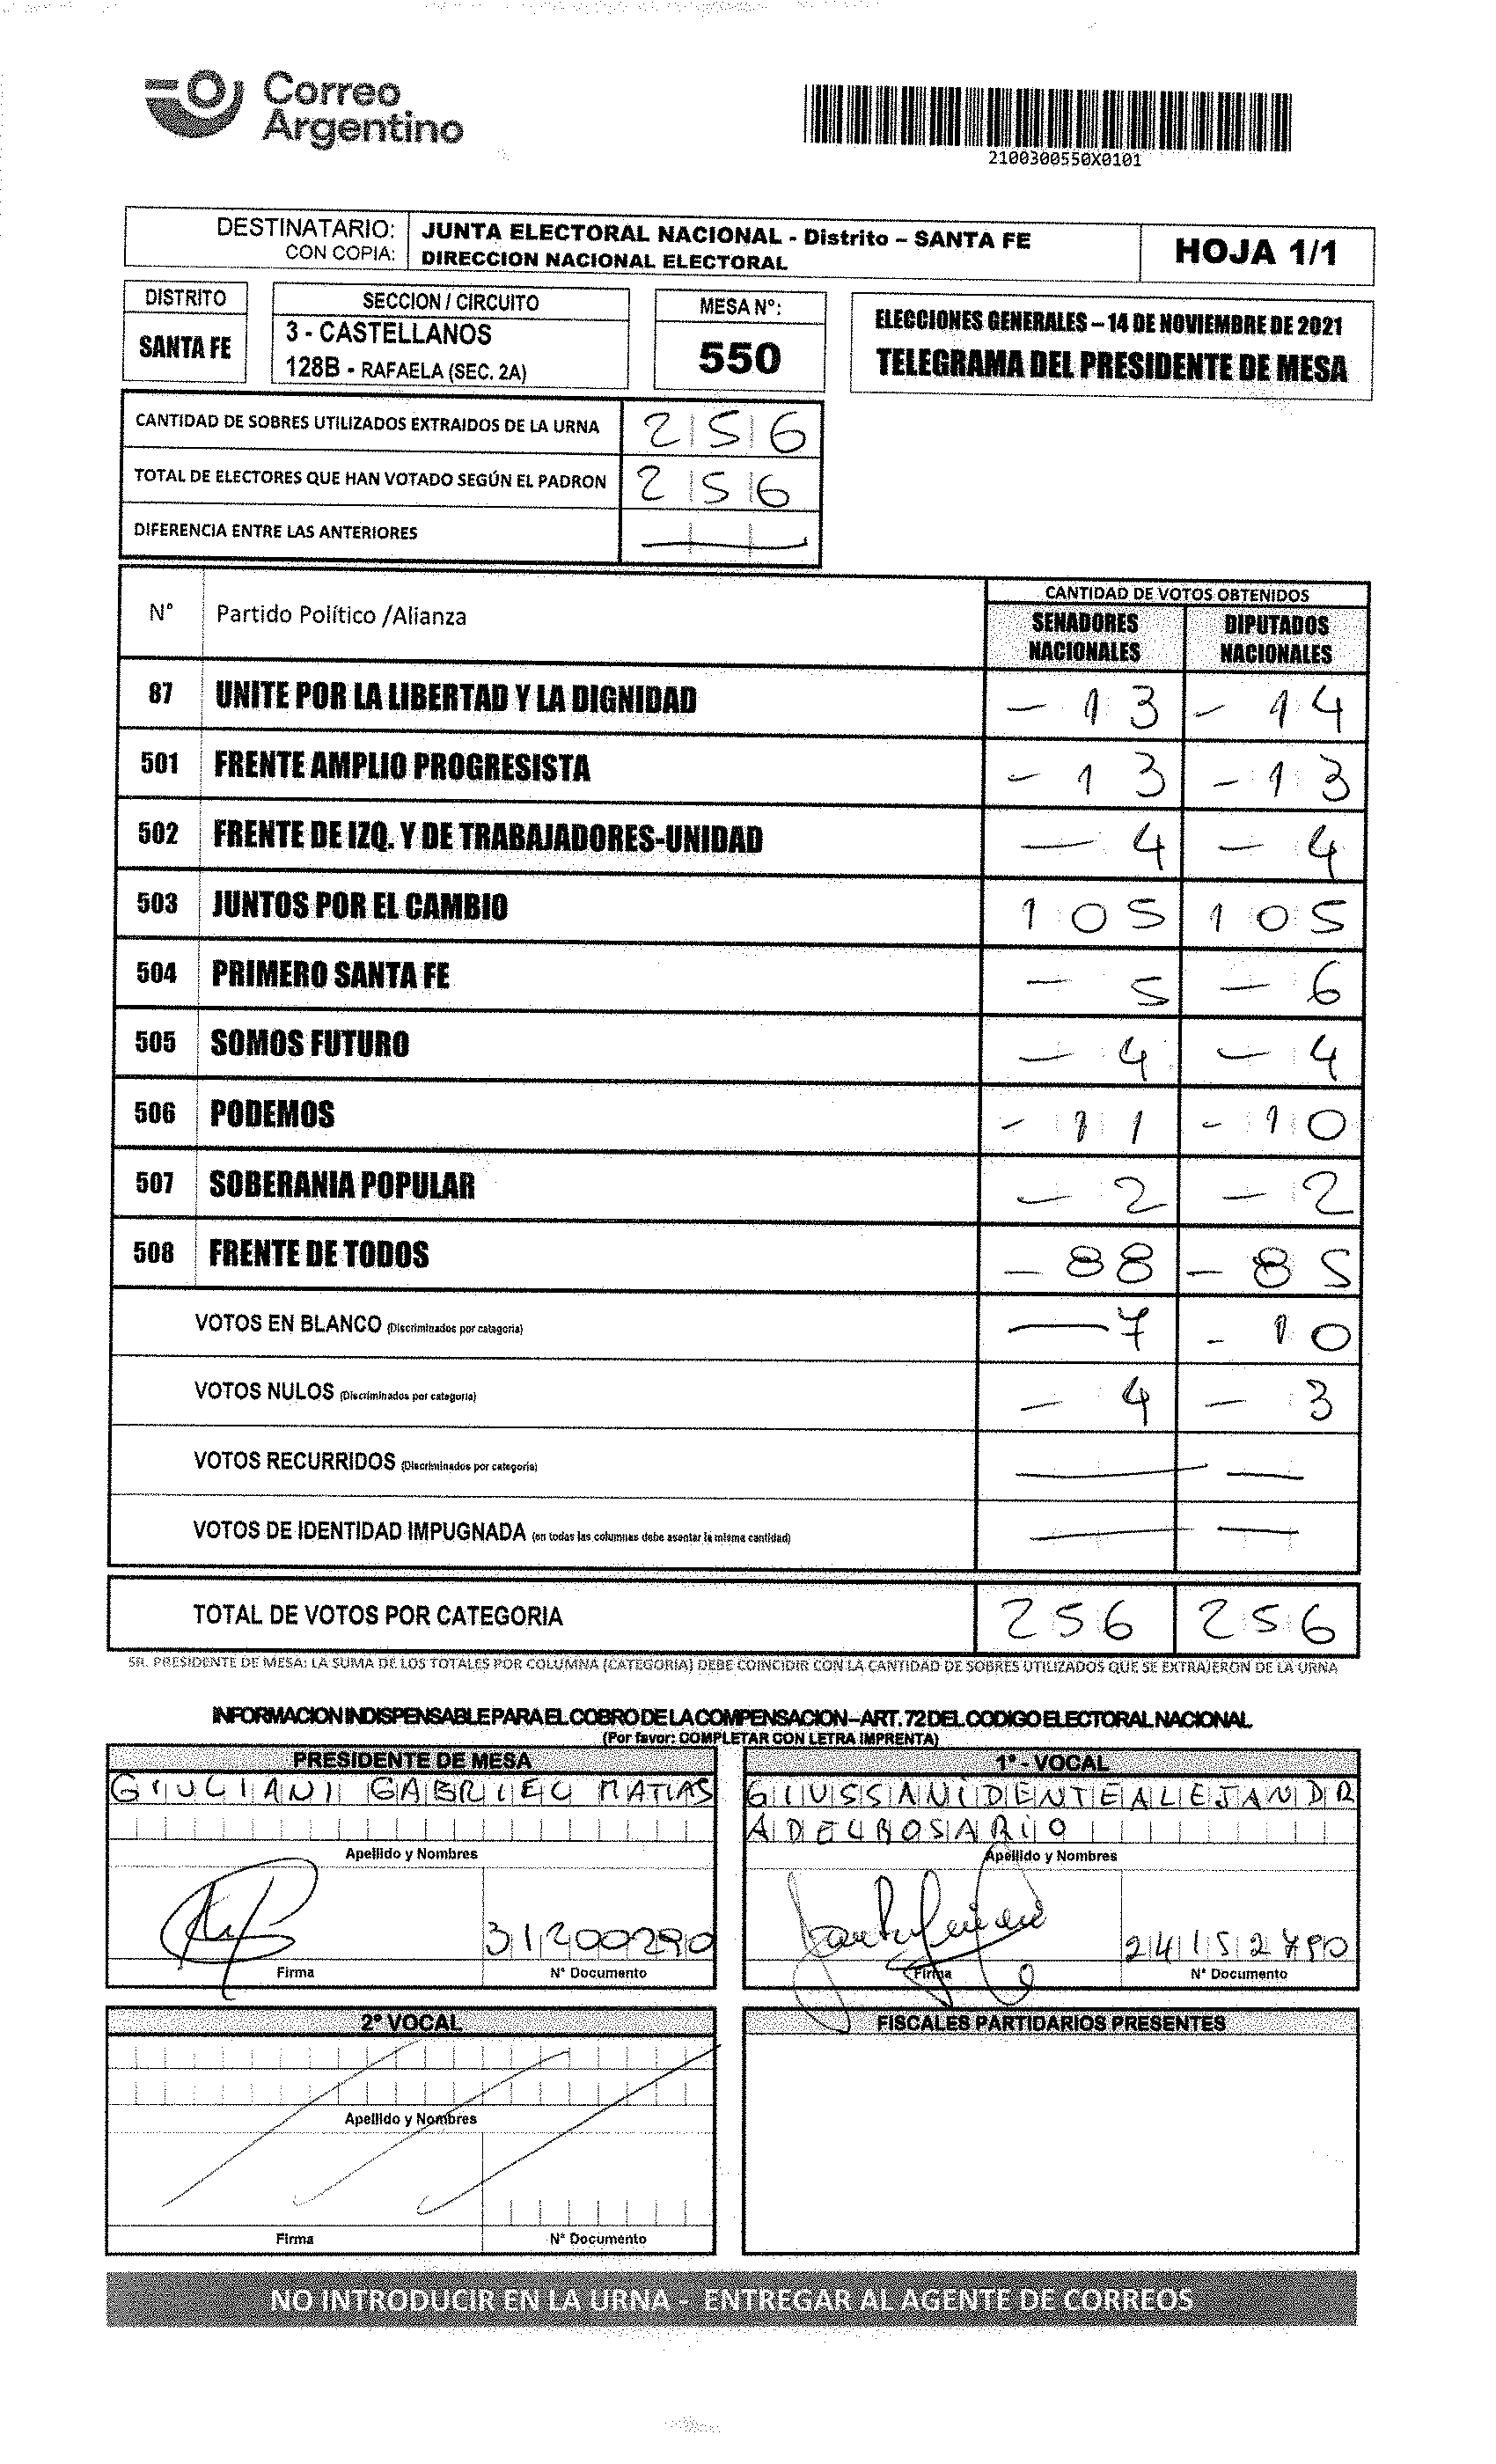

In [12]:
img_id = '2100300550X'

img = cv2.imread(f'D:/Documents/GitHub/medgc-tesis/data/01_raw/telegramas/{img_id}.tiff')

imgshow(img)

Primero tenemos que enderezar la imagen

In [13]:
def get_skew_angle(cvImage) -> float:
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,51,9)

    # Fill rectangular contours
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(thresh, [c], -1, (255,255,255), -1)

    # Morph open
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=4)

    # Draw rectangles
    cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    # Buscar el rectangulo de mayor area
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)


    # Find largest contour and surround in min area box
    largestContour = cnts[0]
    minAreaRect = cv2.minAreaRect(largestContour)

    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90
    if angle > 45:
        angle -= 90
    return -1.0 * angle
  
def rotate_image(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

def deskew(cvImage):
    angle = get_skew_angle(cvImage)
    print(f'skew: {angle}')
    
    if abs(angle) < 30:
        return rotate_image(cvImage, -1.0 * angle)
    return cvImage

skew: -0.6059904098510742


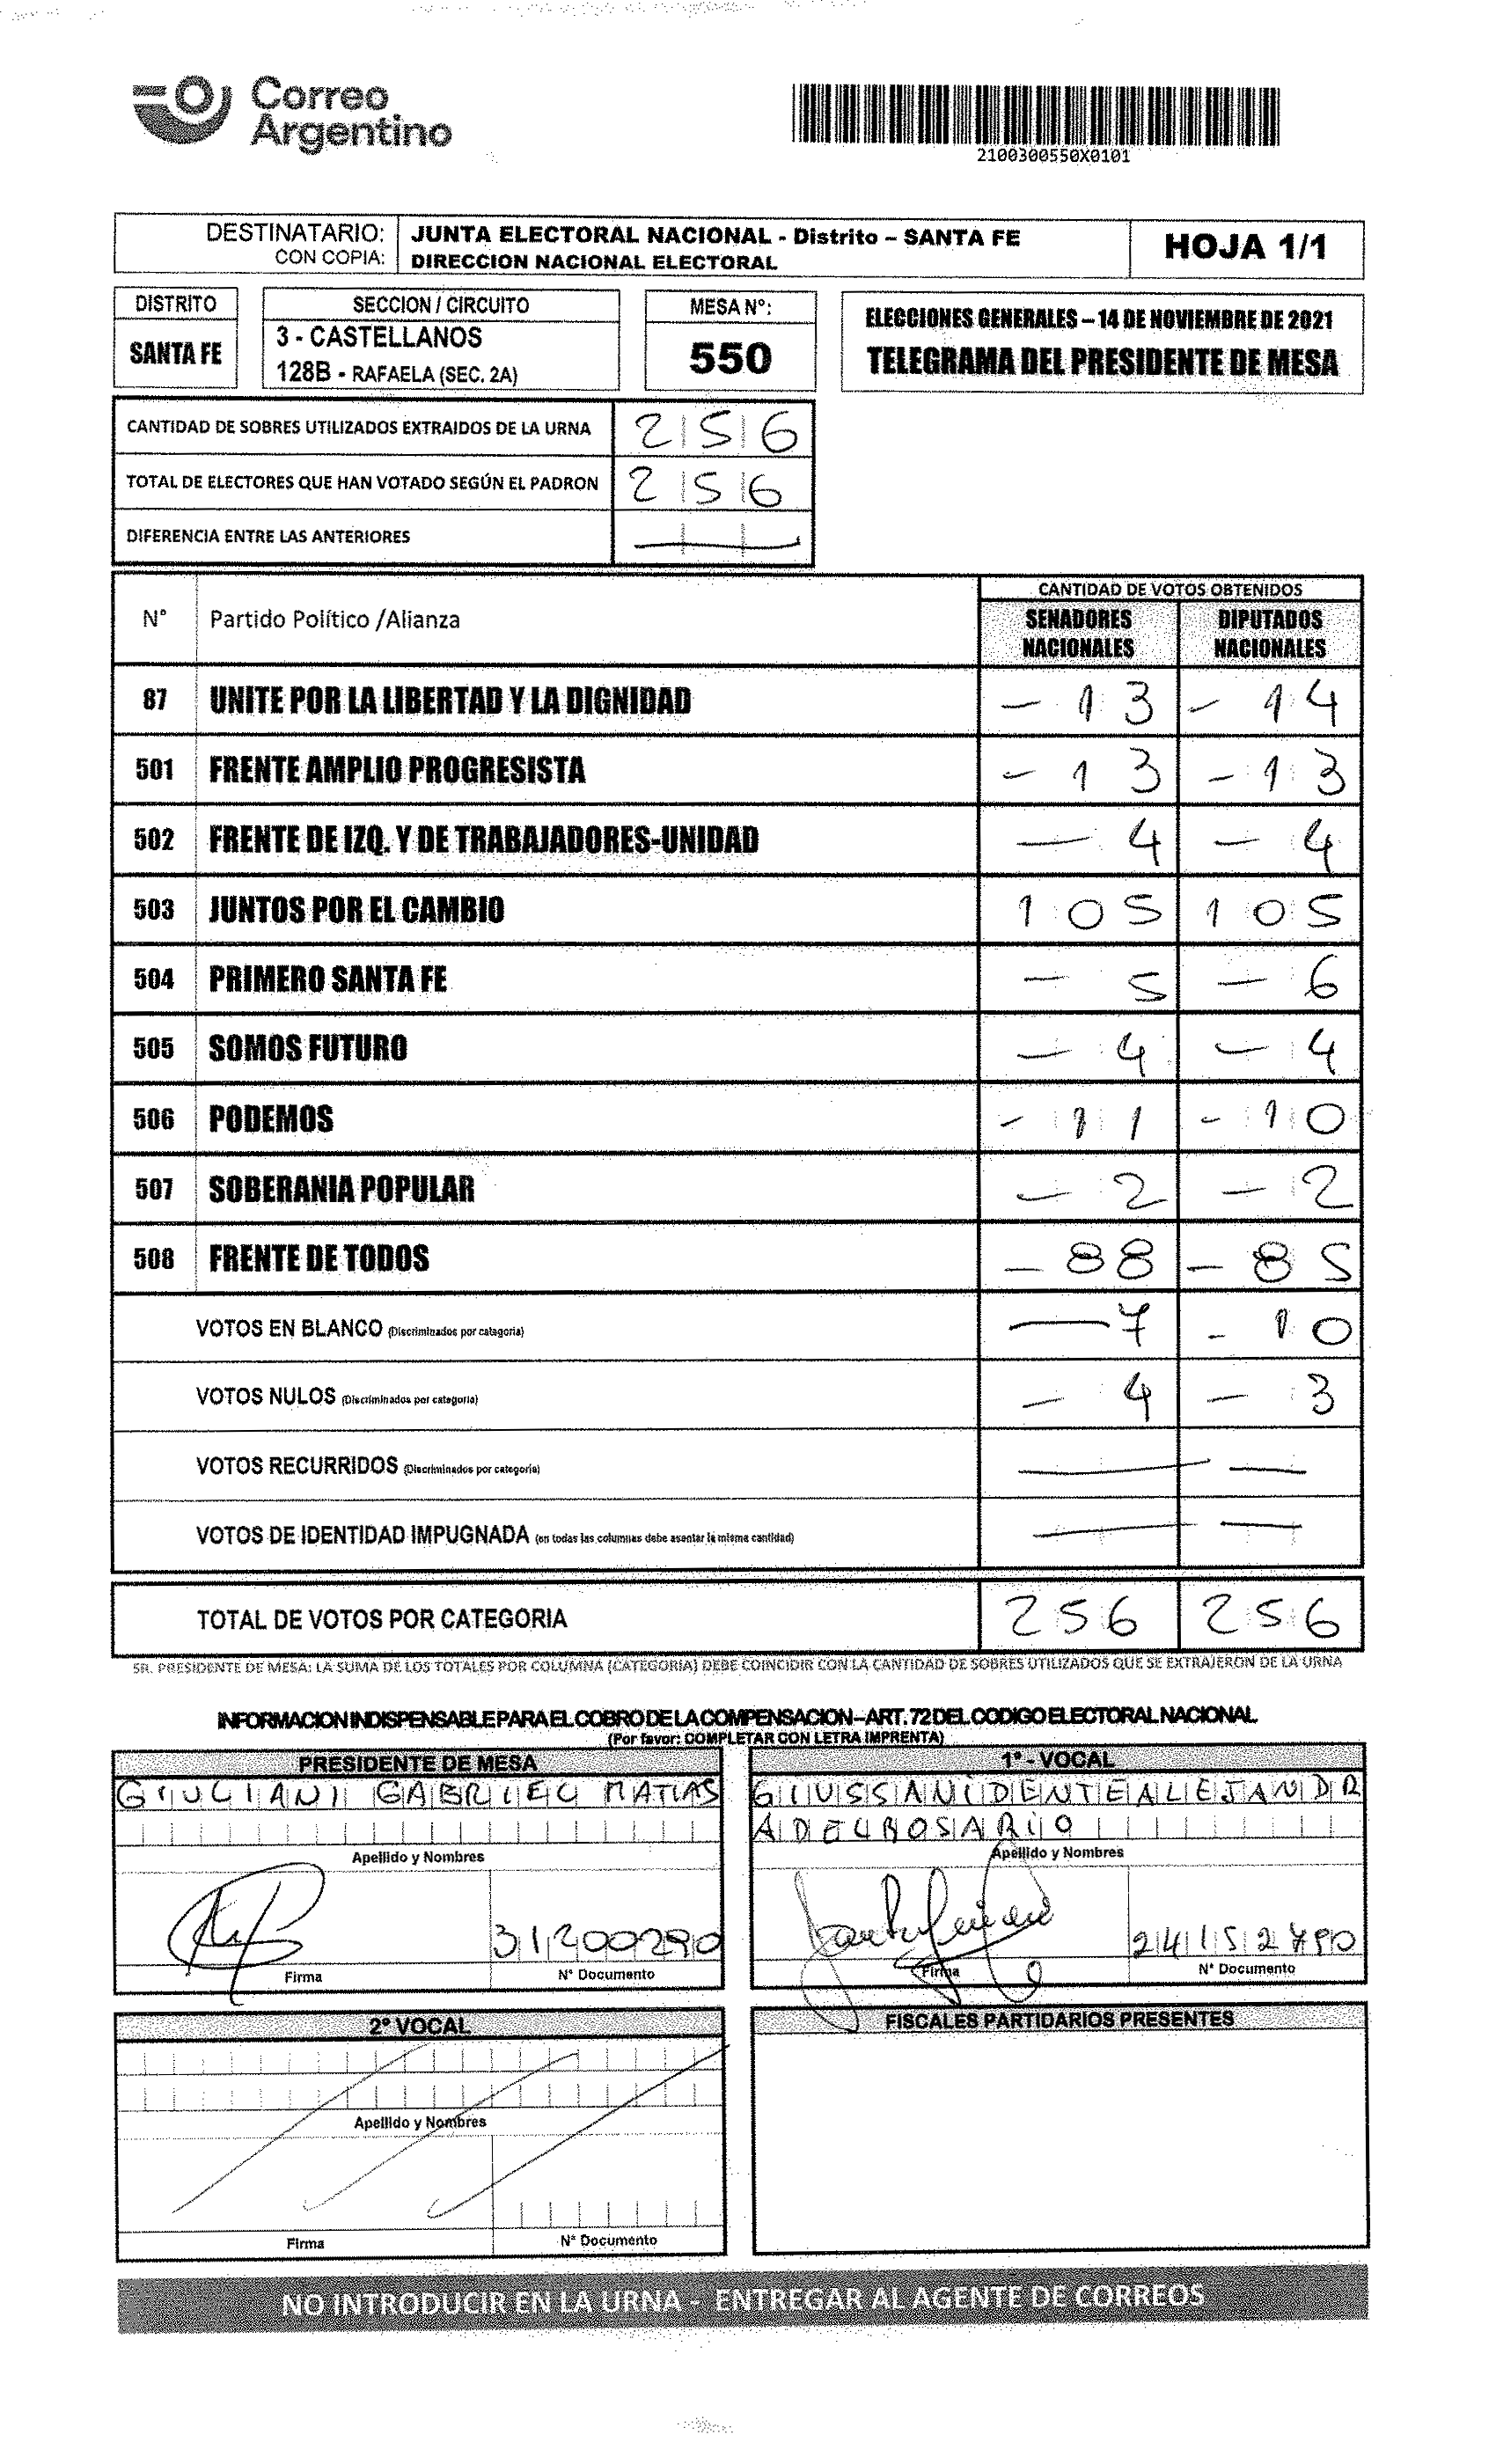

In [14]:
img = deskew(img)

imgshow(img)

Ahora tenemos que quedarnos con la grilla de los votos

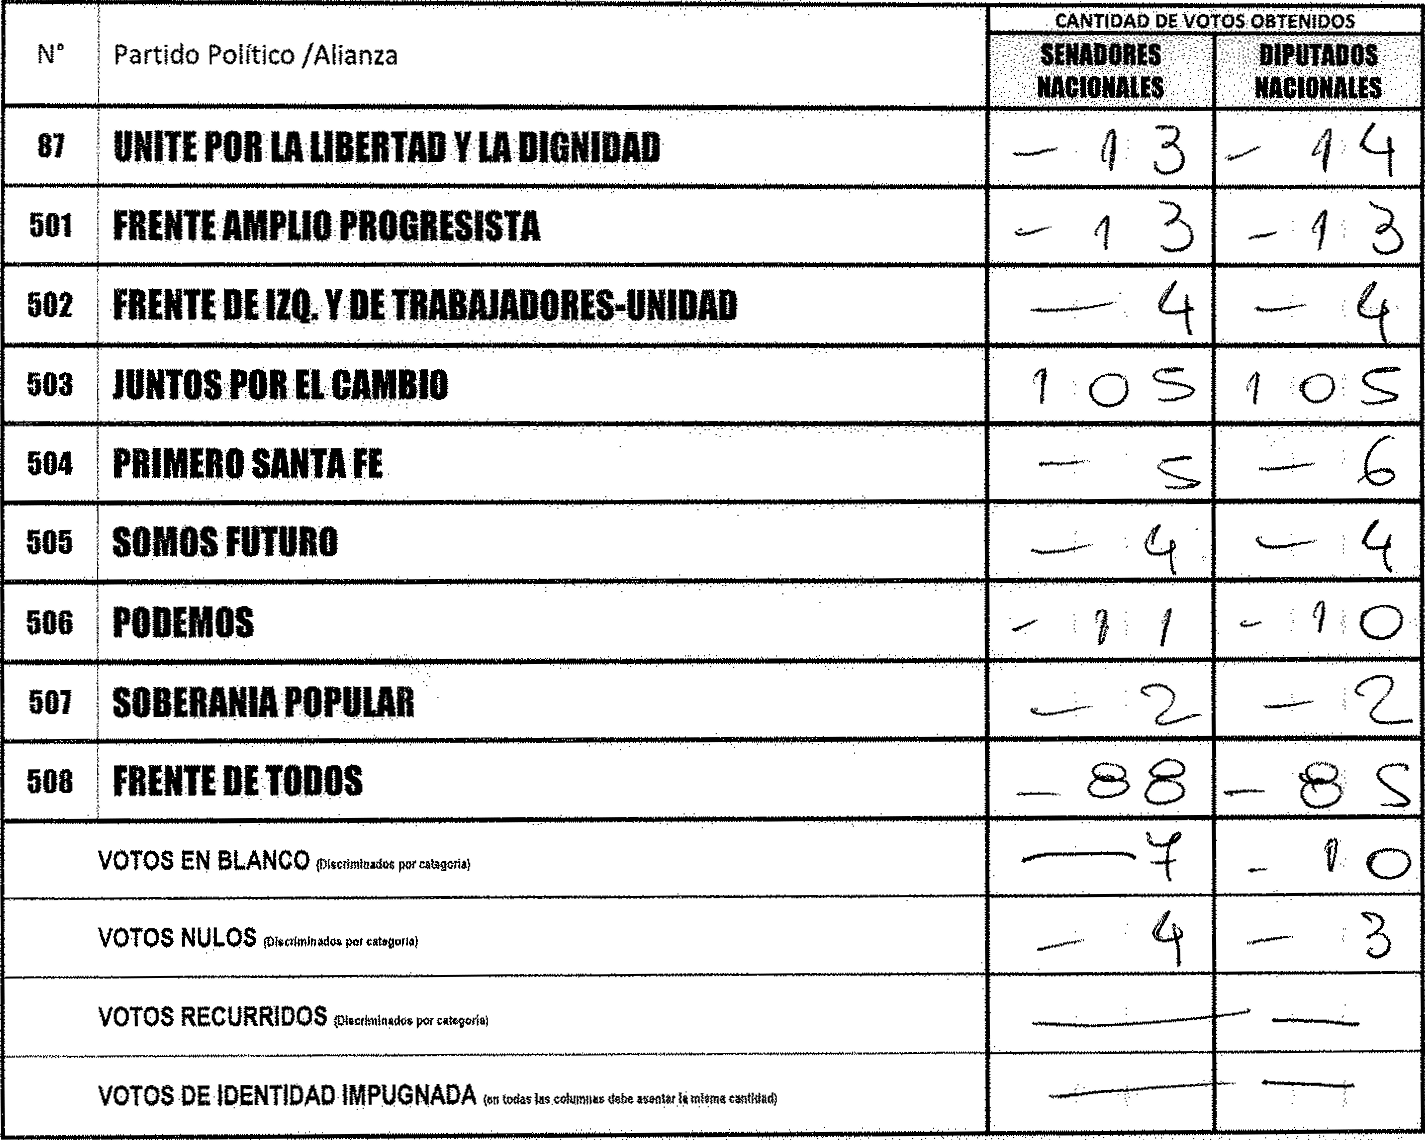

In [5]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,51,9)

# Fill rectangular contours
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(thresh, [c], -1, (255,255,255), -1)

# Morph open
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=4)

# Draw rectangles
cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# Buscar el rectangulo de mayor area
c_max = cnts[0]
area_max = cv2.contourArea(c_max)
for c in cnts:
    area = cv2.contourArea(c)
    if area > area_max:
        area_max = area
        c_max = c
x, y, w, h = cv2.boundingRect(c_max)

# Recortamos la seccion de votos
img_roi = img[y:(y+h), x:(x+w)]

imgshow(img_roi)

In [7]:
(img_roi.shape[0] * img_roi.shape[1]) // 70

23207

In [8]:
(img_roi.shape[0] * img_roi.shape[1]) // 30

54150

Ahora tenemos que detectar las lineas.

Podemos hacer las proyecciones de x e y, y determinar las lineas por la cantida de pixeles negros.

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
img = img_roi.copy()

proyeccion_x = np.sum(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 0)
proyeccion_y = np.sum(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 1)

In [11]:
umbral_x = np.mean(proyeccion_x) - 2 * np.std(proyeccion_x)
x_negros = np.where(proyeccion_x < umbral_x)[0]

x_negros

array([   0,    1,    2,    3,    4,   97,  985,  986,  987,  988,  989,
       1212, 1213, 1214, 1215, 1420, 1421, 1422, 1423, 1424], dtype=int64)

In [12]:
umbral_y = np.mean(proyeccion_y) - 2 * np.std(proyeccion_y)
y_negros = np.where(proyeccion_y < umbral_y)[0]

y_negros

array([   2,    3,    4,    5,  105,  106,  107,  108,  109,  184,  185,
        186,  187,  188,  263,  264,  265,  266,  343,  344,  345,  346,
        347,  421,  422,  423,  424,  425,  500,  501,  502,  503,  579,
        580,  581,  582,  659,  660,  661,  662,  663,  737,  738,  739,
        740,  741,  817,  818,  819,  820,  821,  896,  897,  974, 1133,
       1134, 1135, 1136], dtype=int64)

Hay muchos pixeles parecidos, como el 0, 1, 2, 3 de x.

No tiene sentido trazar 4 lineas verticales juntas, asi que vamos a agrupar los puntos por semajanza y despues nos vamos a quedar con el medio.

Esto lo hacemos con clustering y despues nos quedamos con el punto medio del cluster.

In [13]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from typing import Iterable, Dict

In [14]:
def cluster_projection(projection: np.array, cluster_range: Iterable[int]) -> np.array:
    """
    Genera un agrupamiento optimo segun el silhouette_score de la proyeccion
    """
    best_cluster_model = None
    best_score = 0
    projection_ = projection.reshape(-1, 1)

    for n in cluster_range:
        cluster_model = AgglomerativeClustering(n_clusters=n)
        cluster_model.fit(projection_)
        score = silhouette_score(projection_, cluster_model.labels_)
        if score > best_score:
            best_score = score
            best_cluster_model = cluster_model

    return best_cluster_model.labels_

def mean_by_cluster(items: np.array, clusters: np.array) -> Dict:
    """
    Calcula el valor medio de cada cluster
    """
    means = {}

    for cluster in np.unique(clusters):
        idxs = np.where(clusters == cluster)
        cluster_items = items[idxs]
        cluster_mean = np.mean(cluster_items)
        means[cluster] = min(cluster_items, key=lambda x: abs(x - cluster_mean))

    return means

In [15]:
x_clusters = cluster_projection(x_negros, range(2, 5))
x_means = mean_by_cluster(x_negros, x_clusters)

x_means

{0: 4, 1: 1422, 2: 987, 3: 1213}

In [16]:
y_clusters = cluster_projection(y_negros, range(10, 20))
y_means = mean_by_cluster(y_negros, y_clusters)

y_means

{0: 819,
 1: 739,
 2: 186,
 3: 423,
 4: 661,
 5: 107,
 6: 580,
 7: 3,
 8: 1134,
 9: 896,
 10: 345,
 11: 264,
 12: 501,
 13: 974}

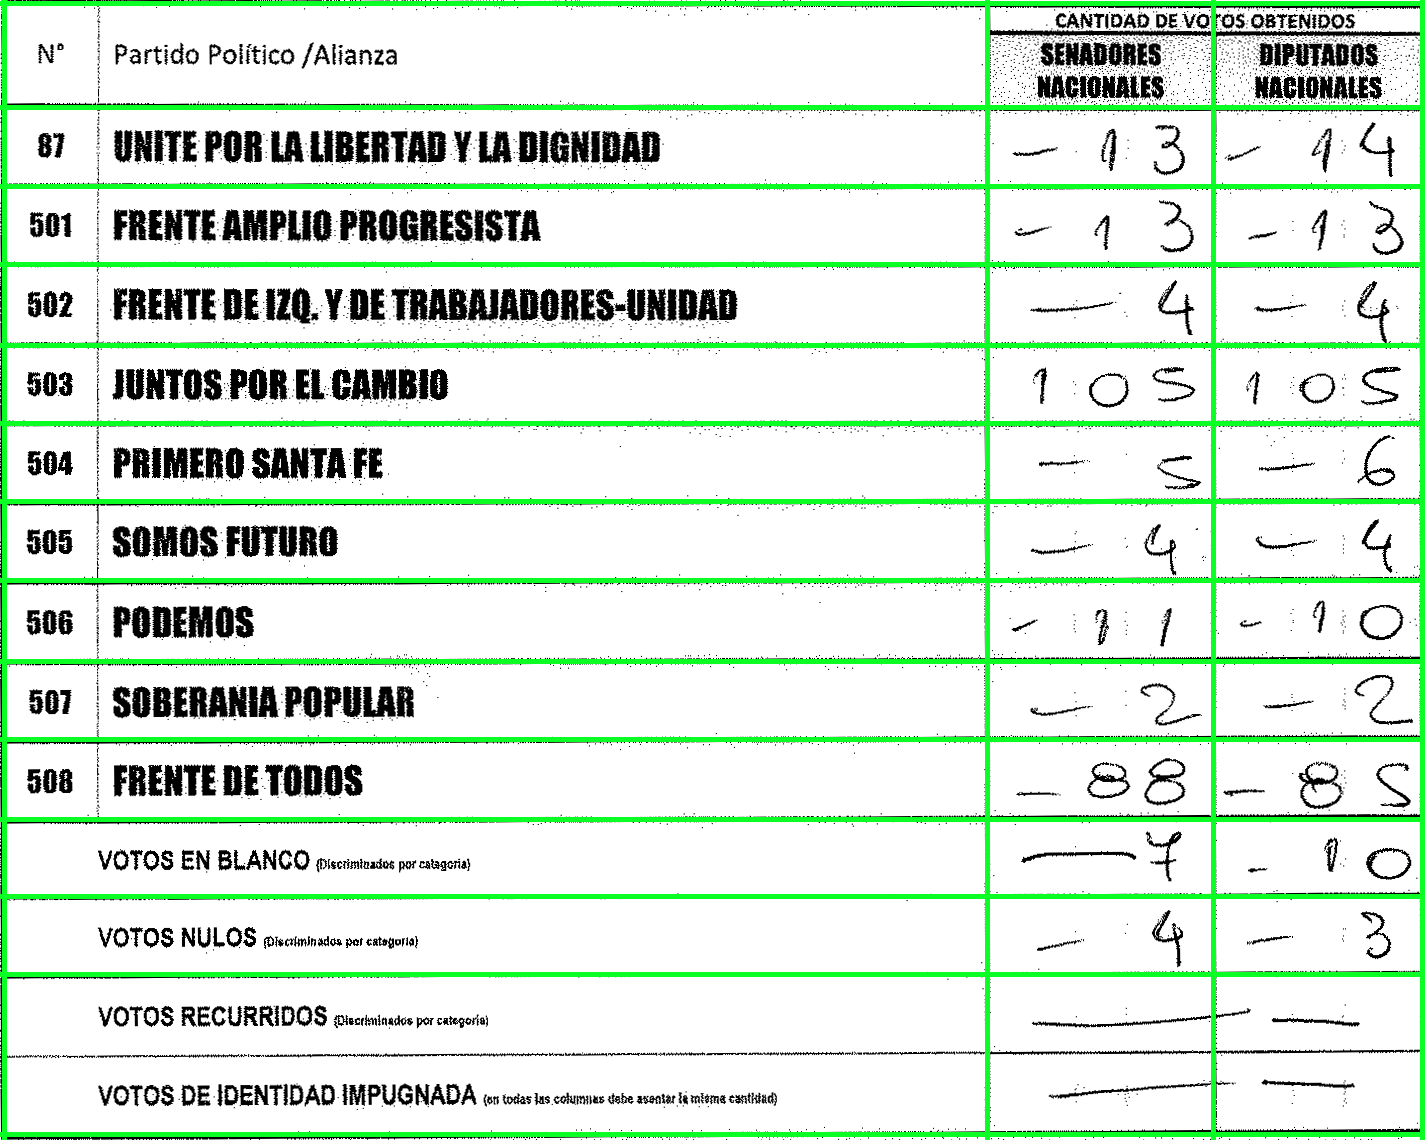

In [17]:
img_temp = img.copy()

for x in x_means.values():
    cv2.line(img_temp, (x, 0), (x, img_temp.shape[0]), (36, 255, 12), 3)

for y in y_means.values():
    cv2.line(img_temp, (0, y), (img_temp.shape[1], y), (36, 255, 12), 3)

imgshow(img_temp)

Ahora las lineas ya estan trazadas, tenemos que tomar cada rectangulo por separado. Para eso tenemos que calcular las intersecciones de las rectas.

In [18]:
from itertools import islice

def window(seq, n=2):
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [19]:
def extract_digit_blocks(xs, ys):
    for y1, y2 in window(ys, n=2):
        for idx, (x1, x2) in enumerate(window(xs, n=2)):
            # eliminamos un par de pixeles para que no se vean los recuadros negros
            offset = 5
            rect = img[y1+offset:y2-offset, x1+offset:x2-offset]
            imgshow(rect)
            
            # salteamos el primer indice de cada row, porque es el titulo del partido politico
            if idx != 0:
                yield rect

In [20]:
xs = sorted(x_means.values())
ys = sorted(y_means.values())

# Vamos a eliminar la primer row (la que tiene los titulos)
# y las ultimas 4 (votos blanco, nulos, recurridos, identidad impugnada)
ys = ys[1:11]

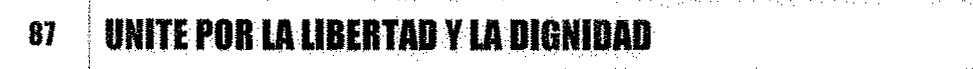

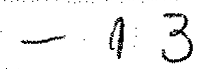

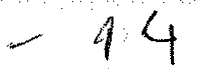

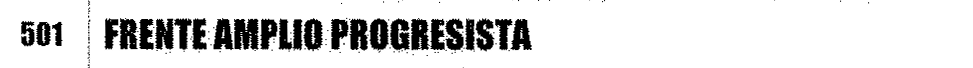

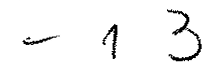

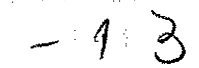

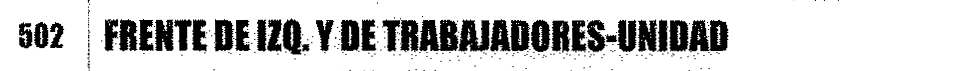

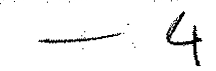

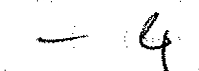

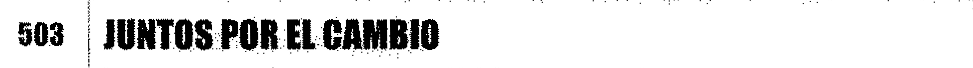

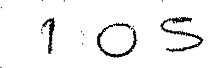

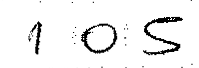

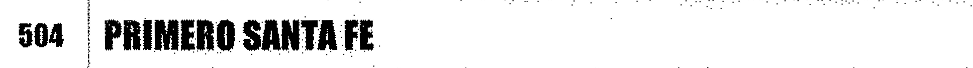

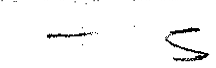

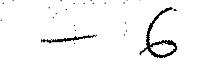

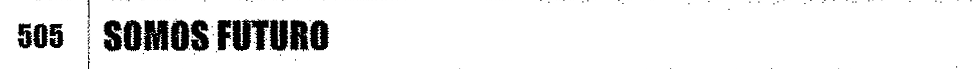

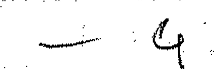

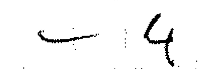

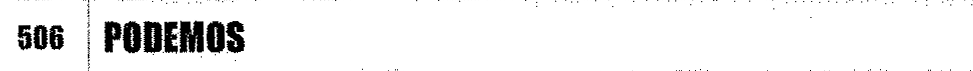

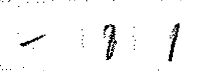

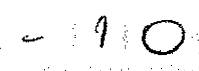

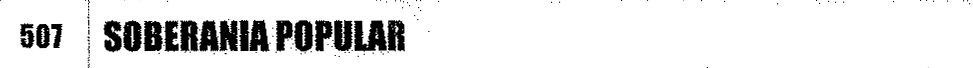

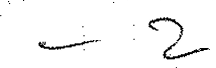

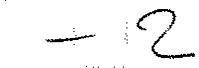

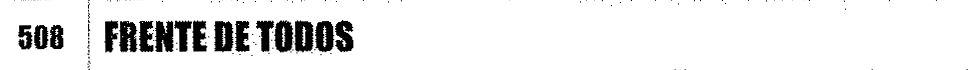

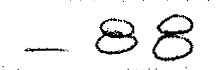

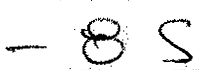

In [21]:
digit_blocks = list(extract_digit_blocks(xs, ys))

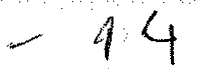

In [22]:
img_prueba = digit_blocks[1]
imgshow(img_prueba)

Ahora tendriamos que segmentar los digitos

In [53]:
def segment_digits(digit_block):
    image = digit_block.copy()

    import functools
    gray = cv2.cvtColor(digit_block, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blurring and thresholding 
    # to reveal the characters on the license plate
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 45, 15)

    # Perform connected components analysis on the thresholded images and
    # initialize the mask to hold only the components we are interested in
    _, labels = cv2.connectedComponents(thresh)
    mask = np.zeros(thresh.shape, dtype="uint8")

    # Set lower bound and upper bound criteria for characters
    total_pixels = image.shape[0] * image.shape[1]
    lower = total_pixels // 70 # heuristic param, can be fine tuned if necessary
    upper = total_pixels // 5 # heuristic param, can be fine tuned if necessary
    print(total_pixels, lower, upper)

    # Loop over the unique components
    for (i, label) in enumerate(np.unique(labels)):
        # If this is the background label, ignore it
        if label == 0:
            continue

        # Otherwise, construct the label mask to display only connected component
        # for the current label
        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)
        print(numPixels)

        # If the number of pixels in the component is between lower bound and upper bound, 
        # add it to our mask
        if numPixels > lower and numPixels < upper:
            mask = cv2.add(mask, labelMask)

    # Find contours and get bounding box for each contour
    cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]

    # Sort the bounding boxes from left to right, top to bottom
    # sort by Y first, and then sort by X if Ys are similar
    def compare(rect1, rect2):
        return rect1[0] - rect2[0]
    boundingBoxes = sorted(boundingBoxes, key=functools.cmp_to_key(compare))

    for x, y, w, h in boundingBoxes:
        img_digit = gray[y:(y+h), x:(x+w)]
        yield img_digit

14688 209 2937
5
14
9
11
5
7
9
4
578
273
4


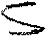

In [60]:
for digit in segment_digits(digit_blocks[-10]):
    imgshow(digit)

Ahora deberiamos hacer cuadrados cada digito, para ser similar al MNIST

In [71]:
def squarify(M, val=255):
    a, b = M.shape
    if a > b:
        pad = (a-b)//2
        offset = 0
        if (a-b) % 2 != 0:
            offset = 1
        padding=((0, 0), (pad + offset, pad))
    else:
        pad = (b-a)//2
        offset = 0
        if (b-a) % 2 != 0:
            offset = 1
        padding=((pad + offset, pad), (0, 0))
    return np.pad(M, padding, mode='constant', constant_values=val)

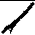

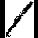

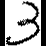

In [72]:
for digit in segment_digits(digit_blocks[6]):
    digit_square = squarify(digit, val=1)
    imgshow(digit_square)

Armamos un dataset final por row

In [73]:
dataset = []
rows = []
for digit_block in digit_blocks:
    row_digits = []
    for digit in segment_digits(digit_block):
        squared_digit = squarify(digit)
        row_digits.append(squared_digit)
    rows.append(row_digits)
        
dataset.append({
    "img_id": img_id,
    "votes": rows
})

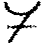

In [74]:
digitos_primer_pp = dataset[0]['votes'][0]
for digito in digitos_primer_pp:
    imgshow(digito)